In [ ]:
from calibration import master_bias, master_flat
import glob

master_bias('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260114/masters', 
            glob.glob(os.path.join('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260114/biases', 'B*.fits')),
            "20260114_masterBIAS_2x2"
)

# master_flat('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260112/masters',
#             glob.glob(os.path.join('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260112/flats', 'F*.fits')),
#             'C:/Users/truji/Desktop/MIT_F25/12_411/data/20260112/masters/20260112_masterBIAS_2x2.fits',
#             "20260112_masterFLAT_SDSSr_2x2"
# )

In [1]:
from astrometry.astrometry import Astrometry

astro = Astrometry("C:/Users/truji/Desktop/MIT_F25/12_411/data/20260112/2012PQ28/", 
                   "/mnt/c/Users/truji/Desktop/MIT_F25/12_411/data/20260112/2012PQ28/")

astro.calibrate_observations('C:/Users/truji/Desktop/MIT_F25/12_411/data/20260112/masters/20260112_masterBIAS_1x1.fits',
                             'C:/Users/truji/Desktop/MIT_F25/12_411/data/20260112/masters/20260112_masterFLAT_SDSSr_1x1.fits',)

astro.center_mask_radius(1000)

Masking Observations: 100%|██████████| 20/20 [00:00<00:00, 59833.15it/s]


In [2]:
astro.get_solutions(xyls=True, sigma=10, fwhm=10, make_plots=False, use_existing=True)

astro.make_converters(degree=3)

Identifying Sources with DAOfind: 100%|██████████| 20/20 [00:00<00:00, 20940.11it/s]
Requesting plate solutions from local Astrometry.net: 100%|██████████| 20/20 [00:00<00:00, 13123.60it/s]
Generating Converters: 100%|██████████| 20/20 [00:00<00:00, 246.35it/s]


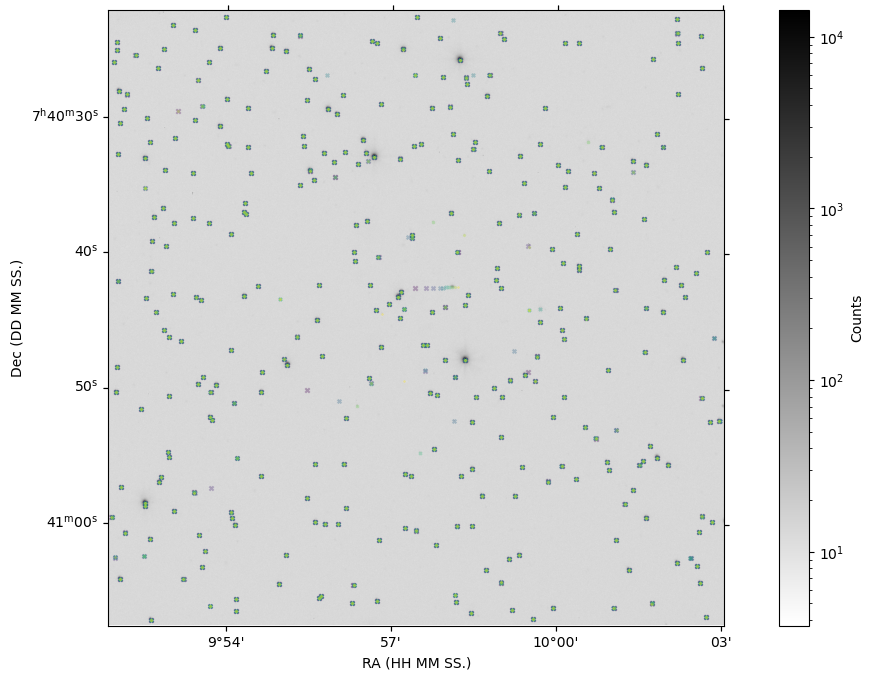

Culling Stationary Sources: 100%|██████████| 10/10 [00:00<00:00, 81.75it/s]

[4, 3, 1, 5, 4, 2, 2, 4, 3, 3]


In [4]:
from tqdm import tqdm
from astropy.coordinates import SkyCoord
from astropy.time import Time
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture
import astropy.units as u

all_sources = []
all_times = []

obs = list(astro.observations.values())[7]

fig = plt.figure(figsize=(14, 8.0))
ax = fig.add_subplot(projection=obs.wcs)

im = ax.imshow(obs.data, cmap="gray_r", norm='log')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts')
ax.set_xlabel("RA (HH MM SS.)")
ax.set_ylabel("Dec (DD MM SS.)")

cmap = plt.cm.viridis
n = len(astro.observations)

for i, (name, obs) in tqdm(enumerate(astro.observations.items()), total=len(astro.observations), desc="Collecting Sources"):
    x_1 = obs.sources["xcentroid"].astype(np.float32)
    y_1 = obs.sources["ycentroid"].astype(np.float32)
    sc = SkyCoord([obs.converter(x, y) for x, y in zip(x_1, y_1)])

    color = cmap(i / max(n - 1, 1))

    ax.scatter(
        sc.ra.deg,
        sc.dec.deg,
        s=n-i,
        marker="x",
        alpha=0.3,
        color=color,
        label=name,
        transform=ax.get_transform('world')
    )

    all_sources.append(sc)
    all_times.append(Time(obs.header.get("DATE-OBS"), scale='utc'))


ax.set_aspect("equal")
ax.relim()
ax.autoscale_view()
plt.show()


tol = 1 * u.arcsec

for i in tqdm(range(len(all_sources)), desc="Culling Stationary Sources"):
    ref = all_sources[i]

    ref_is_static = np.zeros(len(ref), dtype=bool)

    for k in range(len(all_sources)):
        if k == i: continue

        sc = all_sources[k]

        idx_ref, idx_sc, sep2d, _ = sc.search_around_sky(ref, tol)

        ref_is_static[idx_ref] = True

        keep_sc = np.ones(len(sc), dtype=bool)
        keep_sc[idx_sc] = False
        all_sources[k] = sc[keep_sc]

    all_sources[i] = ref[~ref_is_static]

print([len(sources) for sources in all_sources])

[<SkyCoord (ICRS): (ra, dec) in deg
    [(115.17737898,  9.9568841 ), (115.21103006, 10.04380459),
     (115.2031806 ,  9.99125374), (115.20890129,  9.92417318)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17728535, 9.96011708), (115.23914998, 9.89532945),
     (115.16433466, 9.99101048)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17721637, 9.96227516)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17715611, 9.96460019), (115.16155157, 9.95473731),
     (115.19660678, 9.98694537), (115.21226284, 9.93394394),
     (115.21823835, 9.96887848)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17713004, 9.96549554), (115.11163315, 9.93000288),
     (115.11162376, 9.97429343), (115.09457162, 9.96829444)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17710648, 9.96640725), (115.18380062, 9.99494028)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17707635, 9.96737084), (115.22808136, 9.95859624)]>, <SkyCoord (ICRS): (ra, dec) in deg
    [(115.17705558,  9.96826298), (115.21373877,  9.9

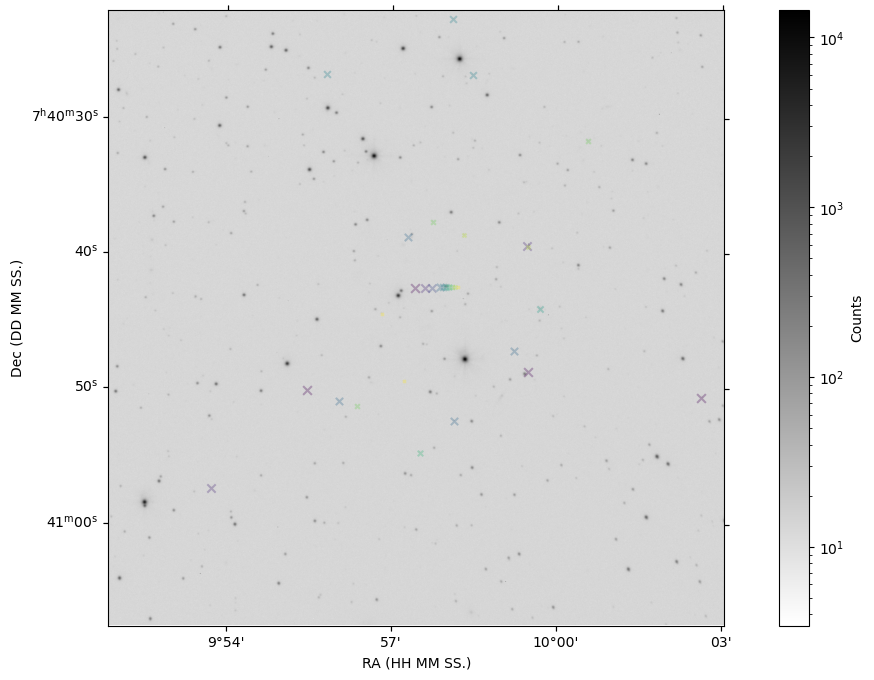

In [10]:
obs = list(astro.observations.values())[5]

fig = plt.figure(figsize=(14, 8.0))
ax = fig.add_subplot(projection=obs.wcs)

im = ax.imshow(obs.data, cmap="gray_r", norm='log')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts')
ax.set_xlabel("RA (HH MM SS.)")
ax.set_ylabel("Dec (DD MM SS.)")

cmap = plt.cm.viridis
n = len(all_sources)
print(all_sources)

for i, sources in enumerate(all_sources):
    print(sources)
    color = cmap(i / max(n - 1, 1))

    ax.scatter(
        sources.ra.deg,
        sources.dec.deg,
        s=(n-i) * 4,
        marker="x",
        color=color,
        alpha=0.3,
        label=name,
        transform=ax.get_transform('world')
    )

In [5]:
def validity_check(chain, tol):
    if len(chain) <= 2:
        # is a source or pair. Always return True
        return True

    # define list indices for obs n-2, n-1, and n
    nm2 = len(chain) - 3
    nm1 = len(chain) - 2
    n = len(chain) - 1

    # get d/dt from n-2 to n-1
    delta_T21 = (all_times[nm1] - all_times[nm2]).to(u.second)

    dra12, ddec12 = (chain[nm2].spherical_offsets_to(chain[nm1]))

    dra12_dt = dra12 / delta_T21
    ddec12_dt = ddec12 / delta_T21

    # get deltaT for n-1 to n
    delta_T23 = (all_times[n] - all_times[nm1]).to(u.second)

    # predict new ra, dec
    pred_delta_ra = dra12_dt * delta_T23
    pred_delta_dec = ddec12_dt * delta_T23

    # make a skycoord with the predicted ra, dec offsets
    pred_sc = chain[nm1].spherical_offsets_by(pred_delta_ra, pred_delta_dec)

    # get angular sep from true coord to pred coord, return True if small enough
    offset = pred_sc.separation(chain[n])
    if offset < tol:
        return True

    # Failed. Return False.
    return False


In [ ]:
c1 = all_sources[0][0]
t1 = all_times[0]

c2 = c1.spherical_offsets_by(0.944*u.deg, 1.1*u.deg)
t2 = t1 + 1*u.second

c3 = c2.spherical_offsets_by(1.022*u.deg, 0.974*u.deg)
t3 = t2 + 1*u.second

print(c1, c2, c3)

all_times = [t1, t2, t3]
worked = validity_check([c1, c2, c3], tol=0.8*u.deg)

print(worked)

<SkyCoord (ICRS): (ra, dec) in deg
    (115.17737831, 9.95689527)> <SkyCoord (ICRS): (ra, dec) in deg
    (116.1390529, 11.05552549)> <SkyCoord (ICRS): (ra, dec) in deg
    (117.18384416, 12.0277387)>
(<Angle 0.944 deg>, <Angle 1.1 deg>)
0.9439999999938277 deg / s 1.0999999999927932 deg / s
0d08m53.45641067s
True


In [7]:
# initialize chains with all sources in first observation
queue = [[source] for source in all_sources[0]]

# possible successes
success = []

# continue until nothing left in chains
while queue:

    # get 'oldest' chain on the stack
    curr = queue.pop(0)

    print(len(queue), len(curr))

    # add new combinations to the queue if they pass filter
    for source in all_sources[len(curr)]:
        new_chain = curr + [source]

        valid = validity_check(new_chain, tol=10*u.arcsec)

        if valid and len(new_chain) == len(all_sources):
            # completed chain that is valid
            success.append(new_chain)
        elif valid:
            queue.append(new_chain)

if not success:
    print("Searched all possible chains and found no potential targets. Perhaps increase tolerance?")
else:
    print(success)

3 1
5 1
7 1
9 1
11 2
11 2
10 2
9 2
8 2
7 2
6 2
5 2
4 2
3 2
2 2
1 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
[[<SkyCoord (ICRS): (ra, dec) in deg
    (115.17737898, 9.9568841)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17728535, 9.96011708)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17721637, 9.96227516)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17715611, 9.96460019)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17713004, 9.96549554)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17710648, 9.96640725)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17707635, 9.96737084)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17705558, 9.96826298)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17702684, 9.96920005)>, <SkyCoord (ICRS): (ra, dec) in deg
    (115.17700231, 9.97011017)>]]


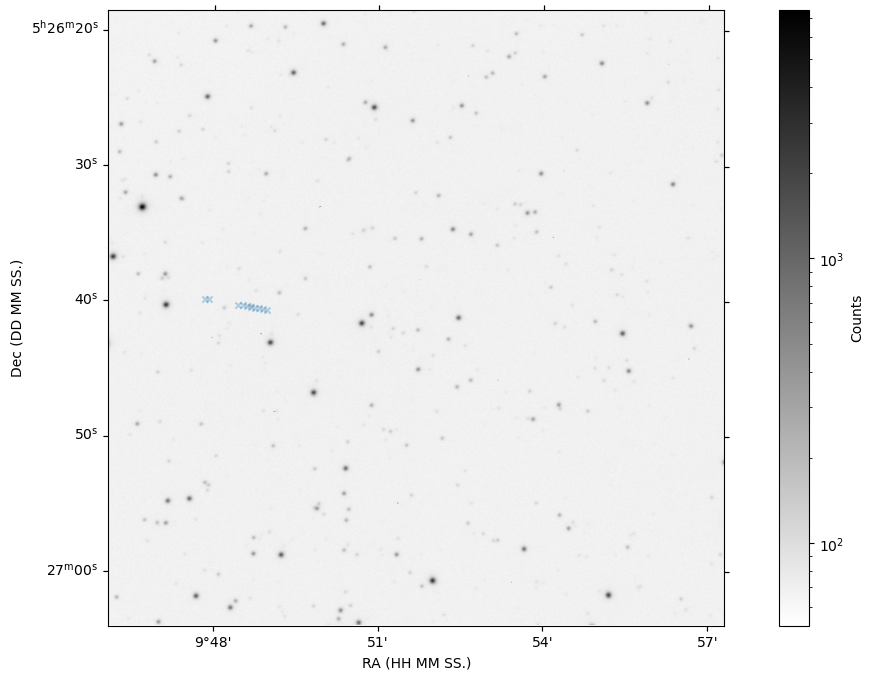

In [11]:
obs = list(astro.observations.values())[5]

fig = plt.figure(figsize=(14, 8.0))
ax = fig.add_subplot(projection=obs.wcs)

im = ax.imshow(obs.data, cmap="gray_r", norm='log')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Counts')
ax.set_xlabel("RA (HH MM SS.)")
ax.set_ylabel("Dec (DD MM SS.)")

for chain in success:
    sc = SkyCoord(chain)

    ax.scatter(
        sc.ra.deg,
        sc.dec.deg,
        s=20,
        marker="x",
        alpha=0.3,
        label=name,
        transform=ax.get_transform('world')
    )

In [3]:
import astropy.units as u

positions = astro.track_objects(["2012PQ28"], rad=10, make_plots=True, stationary_error=1*u.arcsec, prediction_error=3*u.arcsec)

AttributeError: 'Projection' object has no attribute 'xy_to_eq'